# Deep Reinforcement Learning for the CartPole Environment


In [ ]:
!pip install gym
!pip install torch
!pip install copy

In [3]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import numpy as np

import time

## Environment

The CartPole environment consists of a pole which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. The state space is represented by four values: cart position, cart velocity, pole angle, and the velocity of the tip of the pole. The action space consists of two actions: moving left or moving right. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

## OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) aims to provide an easy-to-setup general-intelligence benchmark with various environments. The goal is to get standardized environments.

The cell below defines the "CartPole-v1" environment and its description : 

In [4]:
env = gym.envs.make("CartPole-v1")
spec = gym.spec("CartPole-v1")
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}")

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 475.0


The **CartPole-v1** environment challenges the agent to balance a pole while the agent. The environment has an observation space of 4 continuous numbers:

* Cart Position
* Cart Velocity
* Pole Angle
* Pole Velocity At Tip

To achieve this goal, the agent can take the following actions:

* Push cart to the left
* Push cart to the right

There is also a continuous variant of the mountain car. This version does not simply have the motor on or off. The action space is a single floating-point number for the continuous cart that specifies how much forward or backward force the cart currently utilizes.

## Plotting Function

This function will make it possible to analyze how the agent learns over time. The resulting plot consists of two subplots. The first one plots the total reward the agent accumulates over time, while the other plot shows a histogram of the agent's total rewards for the last 50 episodes. 

In [5]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(475, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-100:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 100 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

## Test Random Environment with OpenAI Gym

The action is sampled randomly from the action space: 

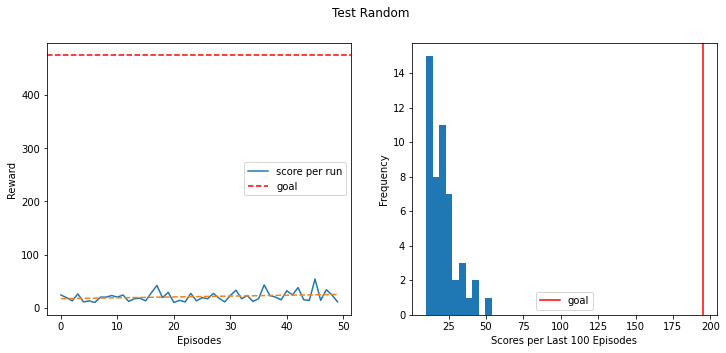

In [7]:
episodes=50
final = []
for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,"Test Random")    

The agent is not learning from their experience. 

## Deep Q-Learning (DQN)
DQN is a RL technique that is aimed at choosing the best action for given circumstances (observation). Each possible action for each possible observation has its Q value, where ‘Q’ stands for a quality of a given move.

 


In [8]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

 

I will explain other parameters later on when we will get to the corresponding agents.

The most straightforward agent updates its Q-values based on its most recent observation. It doesn't have any memory, but it learns by first exploring the environment and the gradually decreasing its epsilon value to make informed decisions:

In [9]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final

### Parameters

In [14]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 170
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

In [16]:
# Get DQN results
simple_dqn = DQN(n_state, n_action, n_hidden, lr)


The graph above shows that the performance of the agent has significantly improved. It got to 175 steps, which, as we've seen before, is impossible for a random agent. The trend line is also positive, and we can see that the performance increases over time. At the same time, the agent didn't manage to get above the goal line after 150 epochs, and its average performance is still around 15 steps, so there is definitely enough room for improvement.

## Replay

The approximation of Q using one sample at a time is not very effective. The graph above is a nice illustration of that. The network managed to achieve a much better performance compared to a random agent. However, it couldn't get to the threshold line of 195 steps. I implemented experience replay to improve network stability and make sure previous experiences are not discarded but used in training.

Experience replay stores the agent's experiences in memory. Batches of experiences are randomly sampled from memory and are used to train the neural network. Such learning consists of two phases--gaining experience and updating the model. The size of the replay controls the number of experiences that are used for the network update. Memory is an array that stores the agent's state, reward, and action, as well as whether the action finished the game and the next state.

In [17]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    
    
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

### replay using old replay function

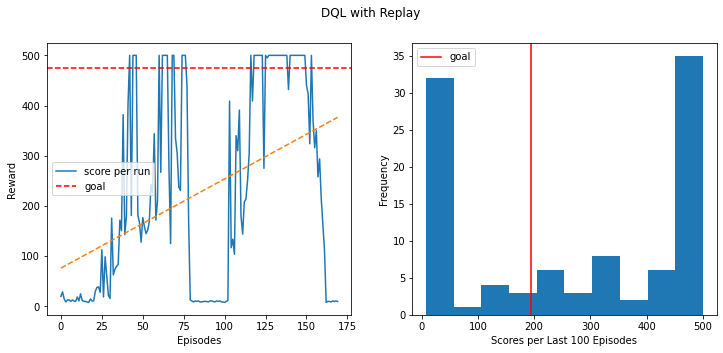

episode: 170, total reward: 10.0
Average replay time: 0.6386126307880178


In [20]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.995, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')